<a href="https://colab.research.google.com/github/CarlosMendez1997Sei/WETSAT_v2/blob/main/2_Modelling_WETSAT_Google_Colab/Wetsat_Geoprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

	Google Colaboratory
	PostgreSQL
	GitHub	     
	Wetlands flooding extent and trends using SATellite data and Machine Learning WETSAT
	Code Developed by
	Carlos Mendez
	Sebastian Palomino
	Camilo Sanabria                     

# Install packages and libraries used in WETSAT

In [2]:
###################################### Artificial Intelligence Frameworks #####################################################
# scikit-learn Framework
!pip install scikit-learn
# Tensorflow Framework
!pip install tensorflow
# Keras Framework
!pip install Keras
###################################### Data, Geoprocessing and Graphics libraries #####################################################
!pip install rasterio
!pip install matplotlib
!pip install numpy
!pip install contextily

# Import libraries and packages

In [1]:
## AI packages
import tensorflow
import keras
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.exceptions import UndefinedMetricWarning

## Geoprocessing packages
import rasterio
from rasterio.features import rasterize
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import os
import contextily as ctx
from shapely.geometry import box
import seaborn as sns
import joblib
import warnings

# Clone Repository from WETSAT [GitHub](https://github.com/sei-latam/WETSAT_v2)

In [3]:
!git clone https://github.com/sei-latam/WETSAT_v2.git

Cloning into 'WETSAT_v2'...
remote: Enumerating objects: 813, done.
remote: Counting objects: 100% (114/114), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 813 (delta 83), reused 48 (delta 48), pack-reused 699 (from 1)
Receiving objects: 100% (813/813), 3.13 GiB | 28.56 MiB/s, done.
Resolving deltas: 100% (160/160), done.
Updating files: 100% (318/318), done.


# Prepare data and first steps

## Import Sentinel-1 Raster Images (VH-VV) and create Polarization Ratio (PR) index

In [2]:
## Access the VH Path
vh_path = "/content/WETSAT_v2/0_Original_Files/aoi2/sigma_dB/VH"
## Access the VV Path
vv_path = "/content/WETSAT_v2/0_Original_Files/aoi2/sigma_dB/VV"
## Create the PR Index path
pr_path = "/content/WETSAT_v2/0_Original_Files/aoi2/sigma_dB/PR_index"

# Create output directory if it doesn't exist
os.makedirs(pr_path, exist_ok=True)

# List VH and VV files (assuming matching filenames)
vh_files = sorted([f for f in os.listdir(vh_path) if f.endswith(".tif")]) # Search files ending with .tif
vv_files = sorted([f for f in os.listdir(vv_path) if f.endswith(".tif")]) # Search files ending with .tif

# Loop through files and compute PR index scaled between 0 and 1
for vh_file, vv_file in zip(vh_files, vv_files):
    # Read the vh_files and vv_files
    with rasterio.open(os.path.join(vh_path, vh_file)) as vh_src, \
         rasterio.open(os.path.join(vv_path, vv_file)) as vv_src:

        vh = vh_src.read(1).astype("float32") # Converts the data to 32-bit float
        vv = vv_src.read(1).astype("float32") # Converts the data to 32-bit float

        vv[vv == 0] = np.nan # Replace zero values in vv/vh path with NaN (Not a Number)
        pr_index = vh / vv # Calculate the Polarization Ratio (VH/VV)

        # Normalize PR index to range [0, 1]
        pr_min = np.nanmin(pr_index) # Returns the smallest non-NaN value in the array.
        pr_max = np.nanmax(pr_index) # Returns the largest non-NaN value.
        pr_index_norm = (pr_index - pr_min) / (pr_max - pr_min) # Normalize the PR Index

        # Save normalized PR index
        profile = vh_src.profile # Creeate a dictionary or profile with info (driver, dtype, count, width and height, crs, transform, nodata, etc.)
        profile.update(dtype="float32", count=1) # Specify that the PR index only have a one band

        pr_filename = f"PR_norm_{vh_file}" # Store pr index according with the name
        with rasterio.open(os.path.join(pr_path, pr_filename), "w", **profile) as dst: # Open a new file with metadata, then constructs the output and store
            dst.write(pr_index_norm, 1) # writes the normalized PR index array to the output raster file:

print("Normalized PR index computation complete.")

Normalized PR index computation complete.


## Calculate General Statistics (minimum and maximum values)

In [3]:
def get_min_max_from_folder(folder_path): # Create a function to scan .tif images
    min_val = np.inf # initialize with the min values
    max_val = -np.inf # initialize with the max values

    for filename in sorted(os.listdir(folder_path)): # Begins a loop that iterates through all files in a folder
        if filename.endswith('.tif'):# Search files ending with .tif
            file_path = os.path.join(folder_path, filename) # Read the files using the path and filename
            with rasterio.open(file_path) as src: # Opens a raster file using rasterio
                data = src.read(1) #reads the first band of the raster file
                # Mask out no-data values if needed
                if src.nodata is not None: # Checks if the data include nodata values
                    data = np.ma.masked_equal(data, src.nodata) # Masks out all pixels without nodata
                min_val = min(min_val, data.min()) # Calculate and update the minimum values across all raster files
                max_val = max(max_val, data.max()) # Calculate and update the maximum values across all raster files

    return min_val, max_val #Return the min and max values

# Call the function and calculate min and max values in vh, vv and pr
vh_min, vh_max = get_min_max_from_folder(vh_path)
vv_min, vv_max = get_min_max_from_folder(vv_path)
pr_min, pr_max = get_min_max_from_folder(pr_path)

#Print the results
print(f"VH min: {vh_min}, VH max: {vh_max}")
print(f"VV min: {vv_min}, VV max: {vv_max}")
print(f"PR min: {pr_min}, PR max: {pr_max}")

VH min: -63.30115509033203, VH max: 14.939030647277832
VV min: -47.164337158203125, VV max: 23.44919204711914
PR min: 0.0, PR max: 1.0


## Plot and visualize the Polarizaton Ratio (PR)

In [6]:
def visualize_images_grid_percentile(folder_path, title_prefix="PR Index"): # Create a function with (folder_path, title_prefix) as parameters
    tif_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.tif')]) # Search and scan in the path all raster images ending with .tif
    num_files = len(tif_files) # Calculate the number and total of files
    images_per_fig = 6 # Configure the number of images per figure

    for i in range(0, num_files, images_per_fig): # Initialize the looping
        fig, axes = plt.subplots(1, images_per_fig, figsize=(18, 3)) # Configure the subplots and size of images (18x3)
        axes = axes.flatten() # Specify that the axes are a flat 1D array

        for j in range(images_per_fig): #  loop that iterates over the number of images you want to display per figure:
            idx = i + j # Calculates the index of the current image file to be processed:
            if idx < num_files: # Verify the index is lower than number of files
                filename = tif_files[idx] # retrieves the filename at the current index from the sorted list of  files:
                with rasterio.open(os.path.join(folder_path, filename)) as src: # This line opens a raster file using its full path:
                    data = src.read(1) # This line reads the first band of the raster file
                    if src.nodata is not None: # Checks whether the raster file has a defined nodata value
                        data = np.ma.masked_equal(data, src.nodata) # smart way to handle missing or invalid data in raster files:

                    # Compute 2nd and 98th percentiles
                    p2 = np.nanpercentile(data, 2)
                    p98 = np.nanpercentile(data, 98)

                    # Clip data to percentile range
                    stretched = np.clip(data, p2, p98)

                    # Plot the images
                    im = axes[j].imshow(stretched, cmap='viridis', vmin=p2, vmax=p98)
                    axes[j].set_title(f"{filename}", fontsize=8) # Print the name of file
                    axes[j].axis('off')
                    fig.colorbar(im, ax=axes[j], shrink=1.0) # Adds a colorbar to the subplot displaying the raster image:
            else:
                axes[j].axis('off')

        plt.tight_layout(rect=[0, 0, 1, 0.95]) # adjusts the layout of your figure to prevent overlapping elements:
        plt.show()

/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:4968: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


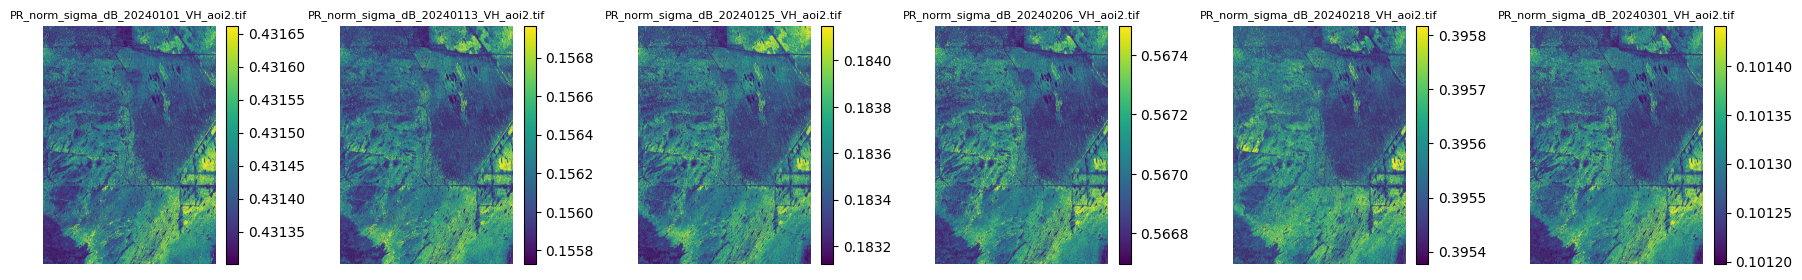

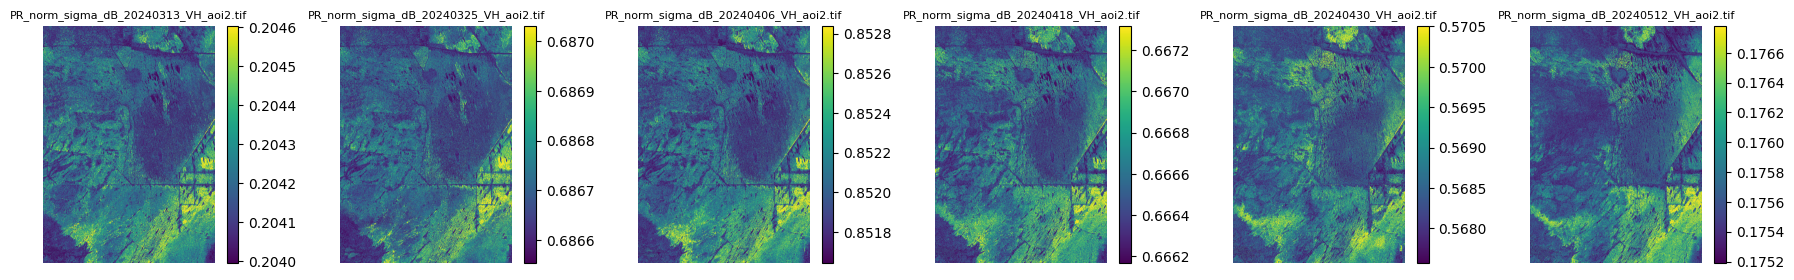

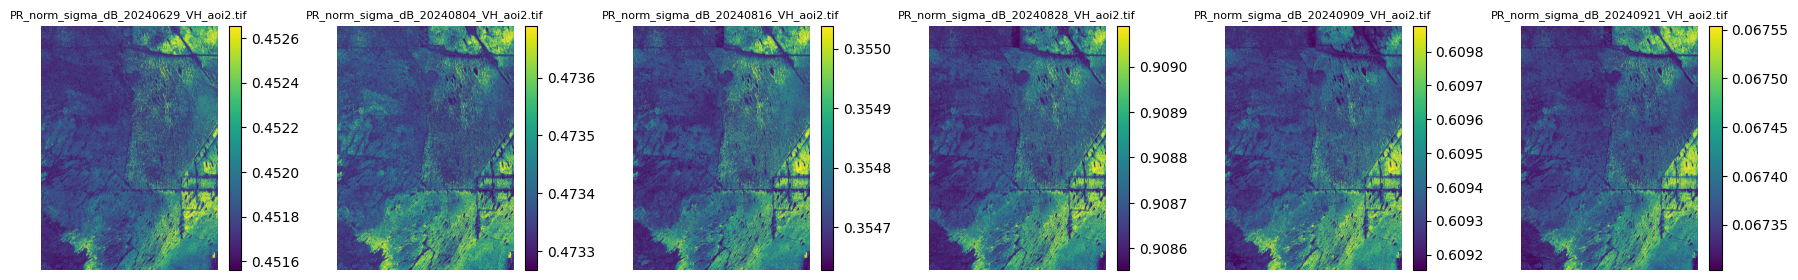

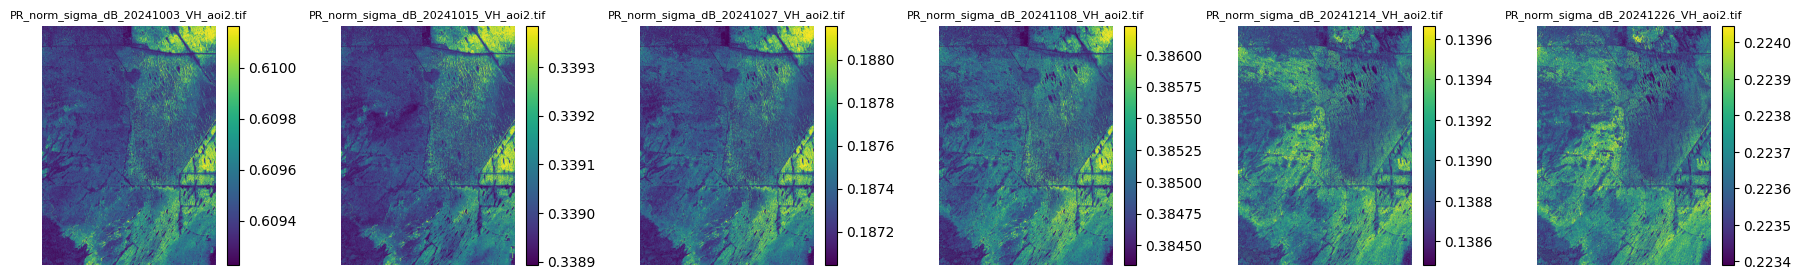

In [7]:
visualize_images_grid_percentile(pr_path, title_prefix="PR Index")

## Plot and visualize the VH and VV images

In [7]:
def visualize_images_grid(folder_path, vmin, vmax, title_prefix): # Create a function with (folder_path, title_prefix) as parameters
    tif_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.tif')]) # Search and scan in the path all raster images ending with .tif
    num_files = len(tif_files) # Calculate the number and total of files
    images_per_fig = 6 # Configure the number of images per figure

    for i in range(0, num_files, images_per_fig): # Initialize the looping
        fig, axes = plt.subplots(1, 6, figsize=(18, 3)) # Configure the subplots and size of images (18x3)
        axes = axes.flatten() # Specify that the axes are a flat 1D array

        for j in range(images_per_fig): #  loop that iterates over the number of images you want to display per figure:
            idx = i + j # Calculates the index of the current image file to be processed:
            if idx < num_files: # Verify the index is lower than number of files
                filename = tif_files[idx] # retrieves the filename at the current index from the sorted list of  files:
                with rasterio.open(os.path.join(folder_path, filename)) as src: # This line opens a raster file using its full path:
                    data = src.read(1) # This line reads the first band of the raster file
                    if src.nodata is not None: # Checks whether the raster file has a defined nodata value
                        data = np.ma.masked_equal(data, src.nodata) # smart way to handle missing or invalid data in raster files:
                    im = axes[j].imshow(data, cmap='viridis', vmin=vmin, vmax=vmax)
                    axes[j].set_title(filename, fontsize=10)  # Print the name of file
                    axes[j].axis('off')
                    fig.colorbar(im, ax=axes[j], shrink=1.0) # Adds a colorbar to the subplot displaying the raster image:
            else:
                axes[j].axis('off')  # Hide unused subplot

        plt.tight_layout(rect=[0, 0, 1, 0.95]) # adjusts the layout of your figure to prevent overlapping elements:
        plt.show()

/usr/local/lib/python3.12/dist-packages/matplotlib/colors.py:777: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


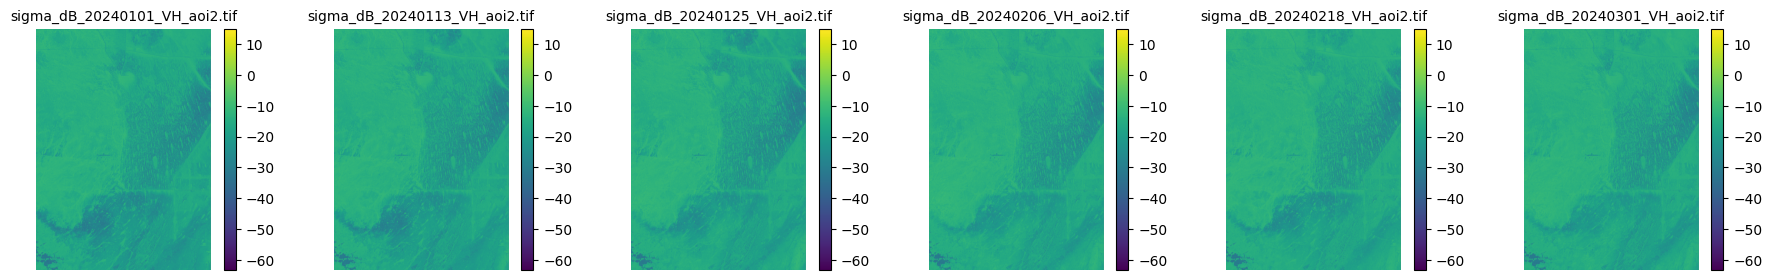

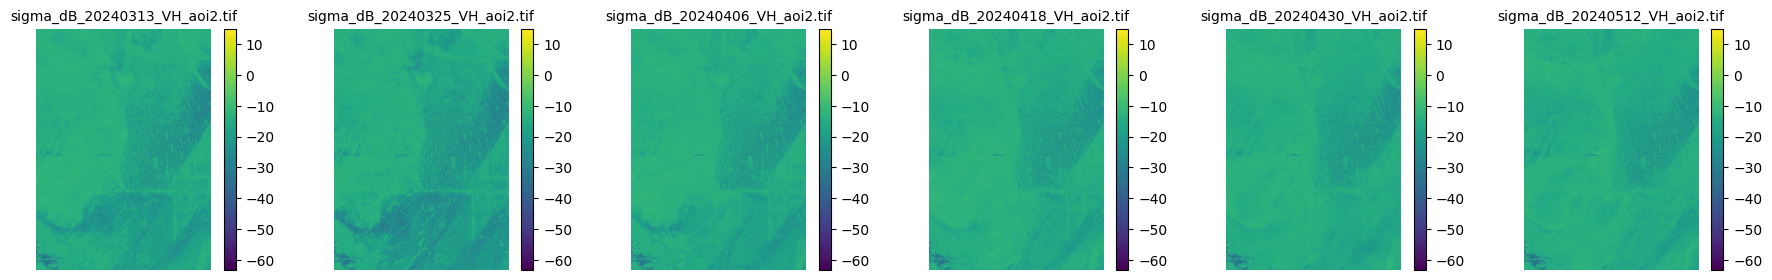

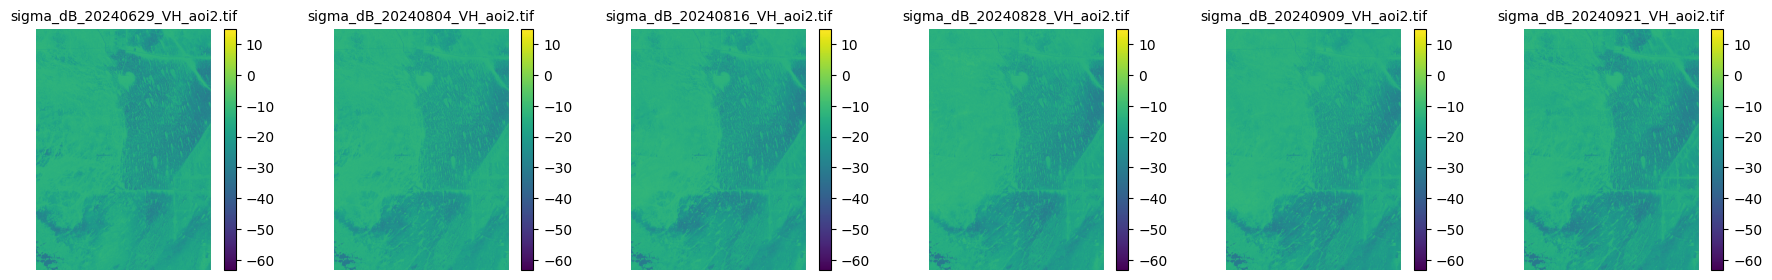

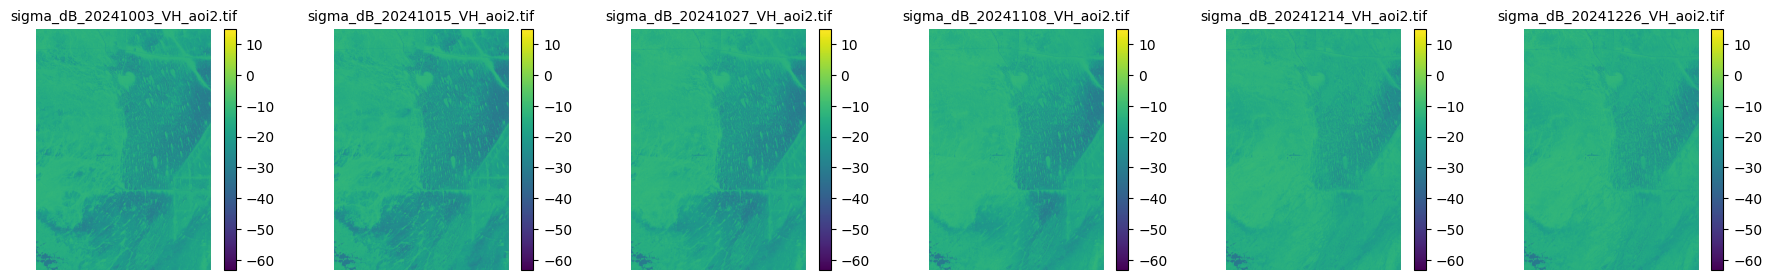

In [9]:
# Visualize each image with consistent scaling
visualize_images_grid(vh_path, vh_min, vh_max, "VH")

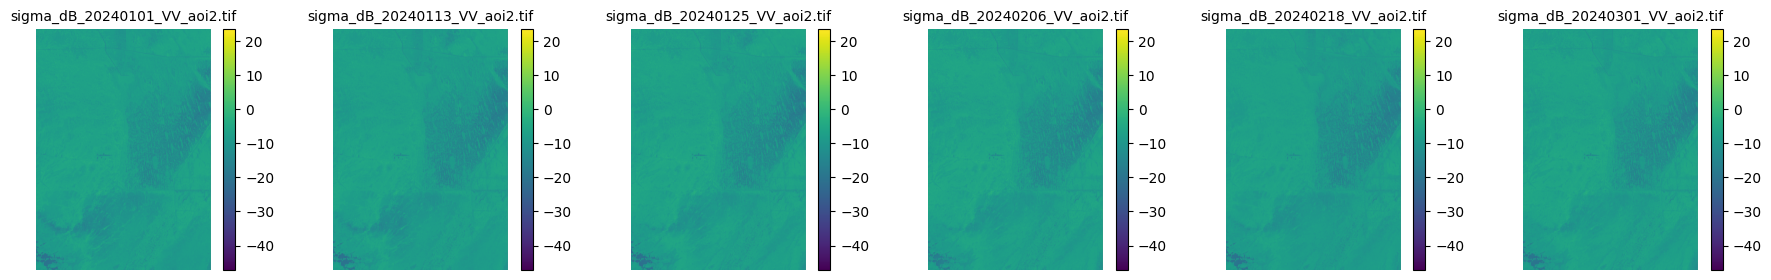

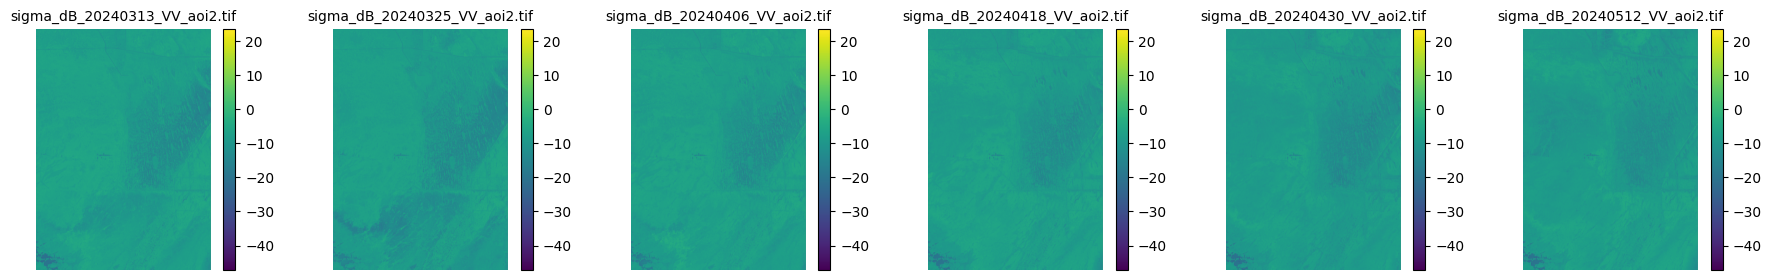

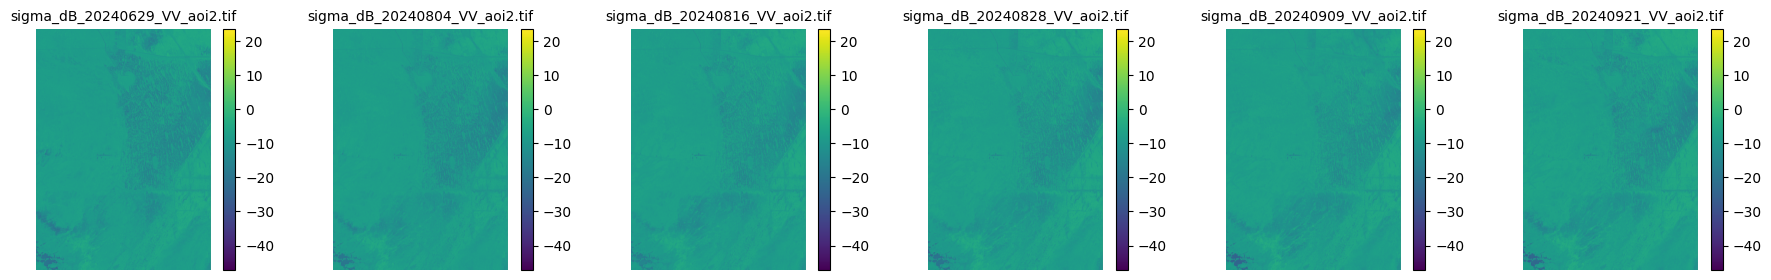

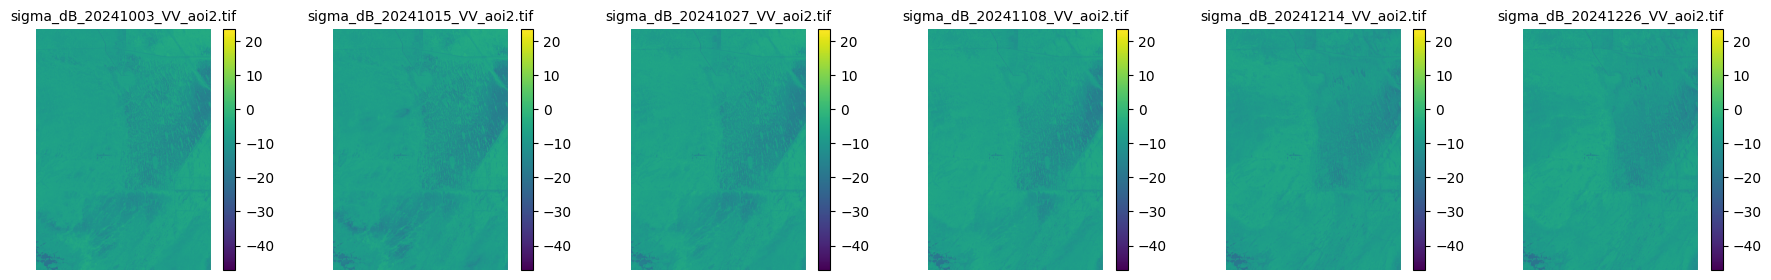

In [10]:
# Visualize each image with consistent scaling
visualize_images_grid(vv_path, vv_min, vv_max, "VV")

## Combine VH-VV-PR data

In [4]:
# Create a function to load images in a folder
def load_images(folder_path): # Create a request 'folder path' as a directory of data
    images = [] # Create a temporal empty array of images
    for file in sorted(os.listdir(folder_path)): # Call the folfer 'path'
        if file.endswith(".tif"): # Search images ending in .tif
            with rasterio.open(os.path.join(folder_path, file)) as src: # Open the images located in folder path
                images.append(src.read(1))
    return np.array(images) # Return array of images

# Call function and load images
vh_images = load_images(vh_path)
vv_images = load_images(vv_path)
pr_images = load_images(pr_path)

print(f"System recognized {vh_images.shape[0]} images VH polarization with size {vh_images.shape[1:]} each one.")
print(f"System recognized {vv_images.shape[0]} images VV polarization with size {vv_images.shape[1:]} each one.")
print(f"System recognized {pr_images.shape[0]} images of PR Index with size {pr_images.shape[1:]} each one.")

assert vh_images.shape == vv_images.shape == pr_images.shape, "The dimensions and size of VH-VV-PR are equal"

# Combine the VH-VV-PR polarization with the same size and dimensions
master_data = np.stack([vh_images, vv_images, pr_images], axis=-1)  # (n_images)

print(f"System combine the VH-VV-PR polarizations wit the size {master_data.shape}")

System recognized 24 images VH polarization with size (3875, 2804) each one.
System recognized 24 images VV polarization with size (3875, 2804) each one.
System recognized 24 images of PR Index with size (3875, 2804) each one.
System combine the VH-VV-PR polarizations wit the size (24, 3875, 2804, 3)


# Import points (.shp) with labels and marks

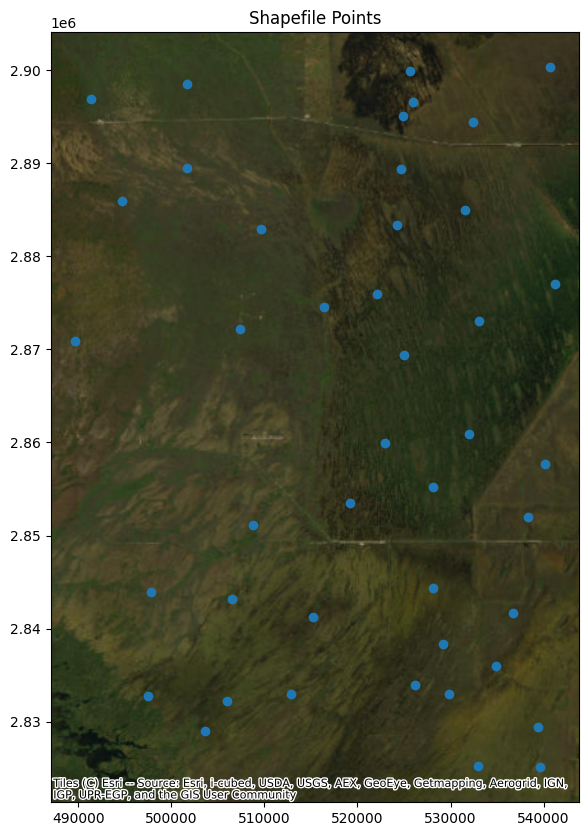

In [5]:
# Load shapefile
shapefile_path = "/content/WETSAT_v2/0_Original_Files/aoi2/points_AOI2_BDE.shp"
gdf = gpd.read_file(shapefile_path)

#providers = ctx.providers
#providers

# Plot the .shp
ax = gdf.plot(figsize=(10, 10))
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.Esri.WorldImagery)
plt.title('Shapefile Points')
plt.show()

## Verify Coordinate Reference System (CRS)

In [6]:
import rasterio
from shapely.geometry import box

# Open a reference raster to get CRS and bounds
with rasterio.open(os.path.join(vh_path, vh_files[0])) as ref:
    raster_crs = ref.crs
    raster_bounds = box(*ref.bounds)

print("The Coordinate Reference System (CRS) is:", raster_crs)

# Reproject shapefile to match raster CRS
gdf = gdf.to_crs(raster_crs)

print("Bounds image:", ref.bounds)
print("Bounds shapefile:", gdf.total_bounds)

# Filter points that fall within the raster extent
gdf_filtered = gdf[gdf.geometry.within(raster_bounds)]
print(f"Points inside raster: {len(gdf_filtered)} of {len(gdf)}")

The Coordinate Reference System (CRS) is: EPSG:32617
Bounds image: BoundingBox(left=488300.0, bottom=2823700.0, right=544380.0, top=2901200.0)
Bounds shapefile: [ 489599.51383088 2825091.04763268  541222.74691443 2900327.16197831]
Points inside raster: 43 of 43


## Create Matrix and Dataframe

In [7]:
# Define label columns
label_columns = [
    '1_01_2024_', '1_13_2024_', '1_25_2024_', '2_06_2024_', '2_18_2024_', '3_01_2024_',
    '3_13_2024_', '3_25_2024_', '4_06_2024_', '4_18_2024_', '4_30_2024_', '5_12_2024_',
    '5_24_2024_', '6_05_2024_', '6_17_2024_', '6_29_2024_', '7_11_2024_', '7_23_2024_',
    '8_04_2024_', '8_16_2024_', '8_28_2024_', '9_09_2024_', '9_21_2024_', '10_03_2024',
    '10_15_2024', '10_27_2024', '11_08_2024', '12_14_2024', '12_26_2024'
]
labels_df = gdf[label_columns]

# Preview the label matrix
print("Extracted label matrix:")
print(labels_df.head(43))

Extracted label matrix:
   1_01_2024_ 1_13_2024_ 1_25_2024_ 2_06_2024_ 2_18_2024_ 3_01_2024_  \
0         e11        e11        e11        e11        e21        e21   
1         e21        e21        e21        e21        e21        e21   
2         e21        e21        e21        e21        e21        e21   
3         e22        e22        e22        e22        e22        e22   
4         e21        e21        e21        e21        e21        e21   
5         e21        e21        e21        e21        e21        e21   
6         e23        e23        e23        e23        e13        e13   
7         e23        e23        e23        e23        e23        e23   
8         e23        e23        e23        e23        e23        e23   
9         e21        e21        e21        e21        e21        e21   
10        e21        e21        e21        e21        e21        e21   
11        e21        e11        e11        e11        e11        e11   
12        e23        e23        e23     

## Calculate only pixels inside coordinate points(.shp)

In [8]:
# Function to get pixel coordinates
def get_pixel_coords(src, point): # Create function with (src and point) as parameters
    return src.index(point.x, point.y) # Returns the values converted from geographic coordinates (point.x and point.y)

with rasterio.open(os.path.join(vh_path, vh_files[0])) as ref: # Open the raster files and then get pixel values
    features = [] # Create an empty list
    for point in gdf.geometry: # Loop to operate through each geometry
        try:
            row, col = get_pixel_coords(ref, point) # Converts geographic point into raster pixel
            pixel_values = master_data[:, row, col, :].flatten() # extracting a time-series feature vector for a single spatial point
        except IndexError: #Exception
            pixel_values = [np.nan] * (master_data.shape[0] * 3) # handle cases where a point falls outside the raster bounds, not receive the three number bands (VH,VV,PR)
        features.append(pixel_values) # appends the extracted or fallback pixel values to your features list:

# Convert to NumPy array
X = np.array(features)

# Check for NaNs
print(f"Rows with NaNs: {np.isnan(X).any(axis=1).sum()} of {X.shape[0]}")

Rows with NaNs: 0 of 43


# Create Random Forest Classifier Model

## Create RF using grid search for each label column separately

### Configure best Hyperparameters

In [9]:
# Suppress warnings for undefined metrics and sparse classes
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

# Filter valid rows (no NaNs in features)
valid_mask = ~np.isnan(X).any(axis=1)
X_clean = X[valid_mask]
labels_clean = labels_df[valid_mask]

# Initialize storage for models and performance metrics
models = {}
scores = {}

### Training (70%) and validation (30%) model and visualize (precision, score and performance)

In [17]:
# Train and tune a model for each label column
for col in labels_clean.columns:
    y = labels_clean[col].values
    y_valid = ~pd.isnull(y)

    X_sub = X_clean[y_valid]
    y_sub = y[y_valid]

    X_tr, X_te, y_tr, y_te = train_test_split(X_sub, y_sub, test_size=0.3, random_state=42)

    rf = RandomForestClassifier(random_state=42)
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1)
    grid_search.fit(X_tr, y_tr)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_te)

    # Store model and accuracy
    models[col] = best_model
    scores[col] = accuracy_score(y_te, y_pred)

    # Save model to disk
    joblib.dump(best_model, f"rf_model_{col}.pkl")

    # Print evaluation
    print(f"\n📅 Results for {col}")
    print("Best Parameters:", grid_search.best_params_)
    print("Confusion Matrix:\n", confusion_matrix(y_te, y_pred))
    print("Classification Report:\n", classification_report(y_te, y_pred))
    print("Accuracy Random Forest Model:", best_model.score(X_te, y_te))  # ← Added line

Fitting 3 folds for each of 48 candidates, totalling 144 fits

📅 Results for 1_01_2024_
Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Confusion Matrix:
 [[0 1 0 0]
 [0 7 0 0]
 [0 2 0 0]
 [0 3 0 0]]
Classification Report:
               precision    recall  f1-score   support

         e11       0.00      0.00      0.00         1
         e21       0.54      1.00      0.70         7
         e22       0.00      0.00      0.00         2
         e23       0.00      0.00      0.00         3

    accuracy                           0.54        13
   macro avg       0.13      0.25      0.17        13
weighted avg       0.29      0.54      0.38        13

Accuracy Random Forest Model: 0.5384615384615384
Fitting 3 folds for each of 48 candidates, totalling 144 fits

📅 Results for 1_13_2024_
Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200

### Plot the metrics and statistics

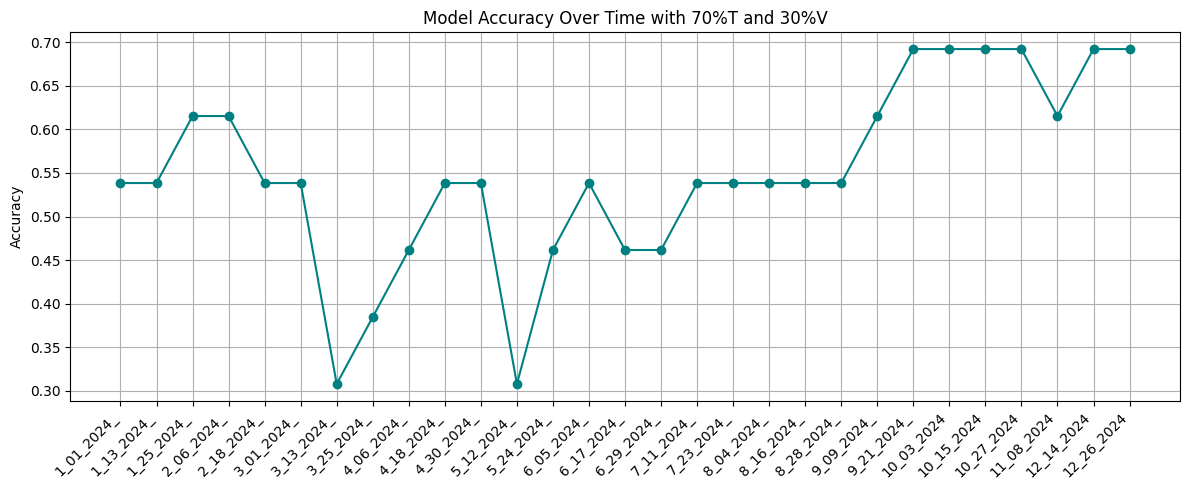

In [19]:
# 📈 Visualize performance over time
plt.figure(figsize=(12, 5))
plt.plot(list(scores.keys()), list(scores.values()), marker='o', linestyle='-', color='teal')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Accuracy")
plt.title("Model Accuracy Over Time with 70%T and 30%V")
plt.grid(True)
plt.tight_layout()
plt.show()

# Load the pre-trained Random Forest stored in Colab

In [10]:
models = {}
for col in label_columns:
    models[col] = joblib.load(f"rf_model_{col}.pkl")

# Prepare raster data (VV,VH and PR) for predictions

In [11]:
n_images, height, width, n_bands = master_data.shape
pixels = master_data.reshape(n_images, height * width, n_bands)  # shape: (n_images, n_pixels, 3)
pixels = pixels.transpose(1, 0, 2).reshape(height * width, -1)   # shape: (n_pixels, n_images * 3)

# Clean and impute missing data

In [ ]:
imputer = SimpleImputer(strategy='mean')
pixels_imputed = imputer.fit_transform(pixels)

### Training (80%) and validation (20%) model and visualize (precision, score and performance)

# Option 2: Grid Search for Multi-Output Classification

In [ ]:

# Filter rows with complete labels
full_mask = valid_mask & ~labels_df.isnull().any(axis=1)
X_multi = X[full_mask]
y_multi = labels_df[full_mask]

# Define base estimator and grid
rf = RandomForestClassifier(random_state=42)
multi_clf = MultiOutputClassifier(rf)

param_grid = {
    'estimator__n_estimators': [100, 200],
    'estimator__max_depth': [10, 20, None],
    'estimator__min_samples_split': [2, 5],
    'estimator__min_samples_leaf': [1, 2],
    'estimator__max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(estimator=multi_clf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_multi, y_multi)

# Evaluate each output
best_multi_model = grid_search.best_estimator_
y_pred_multi = best_multi_model.predict(X_multi)

for i, col in enumerate(labels_df.columns):
    print(f"\n📅 Results for {col}")
    print("Best Parameters:", grid_search.best_params_)
    print("Classification Report:\n", classification_report(y_multi[col], y_pred_multi[:, i]))


Fitting 3 folds for each of 48 candidates, totalling 144 fits

📅 Results for 1_01_2024_
Best Parameters: {'estimator__max_depth': 10, 'estimator__max_features': 'log2', 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__n_estimators': 200}
Classification Report:
               precision    recall  f1-score   support

         e11       1.00      1.00      1.00         2
         e21       1.00      1.00      1.00        27
         e22       1.00      1.00      1.00         9
         e23       1.00      1.00      1.00         5

    accuracy                           1.00        43
   macro avg       1.00      1.00      1.00        43
weighted avg       1.00      1.00      1.00        43


📅 Results for 1_13_2024_
Best Parameters: {'estimator__max_depth': 10, 'estimator__max_features': 'log2', 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__n_estimators': 200}
Classification Report:
               precision    recall  f1-s

# Prepare training data

In [ ]:
# Create x and y train data
X_train = []
y_train = []

# Call function to iterate or looping in each image from master_data dataset
for i in range(master_data.shape[0]): #Calculate the size of master_data
    img = master_data[i]  # Receive height and weight
    img_flat = img.reshape(-1, 2) # Transform the image into an array, when -1 meaning automatic fields and 2 set number of rows
    labels_flat = raster_labels.flatten()
    mask = labels_flat > 0 #Validate only labels > 0

    #Filter or mask data in x/y training data
    X_train.append(img_flat[mask])
    y_train.append(labels_flat[mask])

# concatenate data
X_train = np.concatenate(X_train, axis=0)
y_train = np.concatenate(y_train, axis=0)

print(f"Total samples: {X_train.shape[0]}")

X_tr, X_te, y_tr, y_te = train_test_split(X_train, y_train, test_size=0.3)

NameError: name 'raster_labels' is not defined

# Random Forest (RF) Model

In [ ]:
# Define the hyperparameters and grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Initialize the RF model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_tr, y_tr)
print("Accuracy Random Forest Model:", rf.score(X_te, y_te))

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=rf,
                           param_grid=param_grid,
                           cv=3,  # 3-fold cross-validation
                           verbose=2,
                           n_jobs=-1)  # Use all available cores

# Fit to training data
grid_search.fit(X_tr, y_tr)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)


Accuracy Random Forest Model: 0.7704918032786885
Fitting 3 folds for each of 243 candidates, totalling 729 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
243 fits failed out of a total of 729.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
124 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.12/dist-packages/sklearn/util

Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Cross-Validation Score: 0.7256205673758865


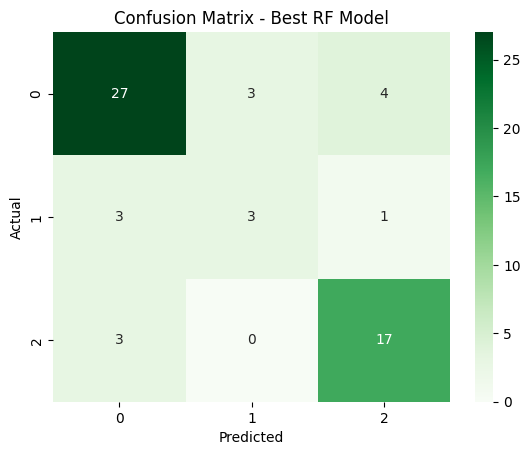

              precision    recall  f1-score   support

          22       0.82      0.79      0.81        34
          24       0.50      0.43      0.46         7
          26       0.77      0.85      0.81        20

    accuracy                           0.77        61
   macro avg       0.70      0.69      0.69        61
weighted avg       0.77      0.77      0.77        61



In [ ]:
best_rf = grid_search.best_estimator_
y_pred_best = best_rf.predict(X_te)

# Confusion Matrix
cm_best = confusion_matrix(y_te, y_pred_best)
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - Best RF Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report
print(classification_report(y_te, y_pred_best))

## Plot and visualize first image

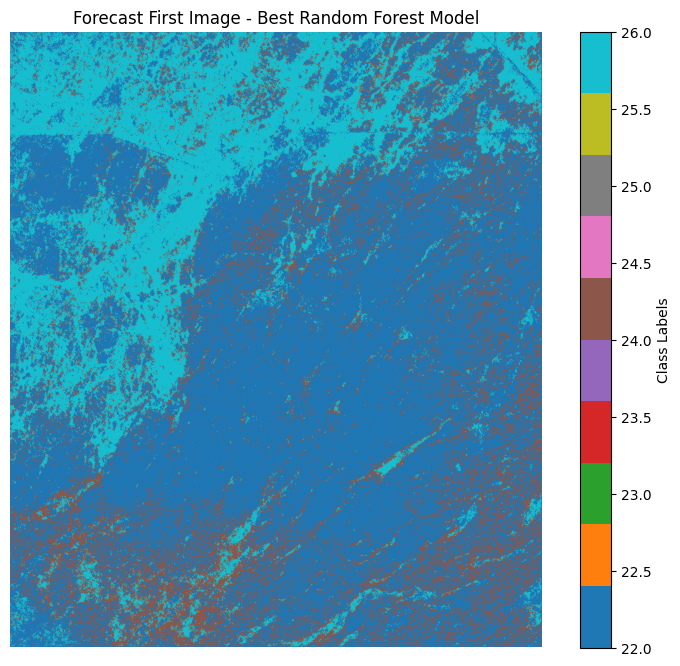

In [ ]:
img = master_data[0] # Select an Image S1 (combined VH/VV)

height, width = img.shape[:2] # select first image

# Create a new organization of data to forecast pixels
img_flat = img.reshape(-1, 2)

# Predict with best model
predicted_labels_best = best_rf.predict(img_flat)
predicted_raster_best = predicted_labels_best.reshape(height, width)

# Visualize results
plt.figure(figsize=(10, 8))
plt.imshow(predicted_raster_best, cmap='tab10')
plt.title("Forecast First Image - Best Random Forest Model")
plt.colorbar(label='Class Labels')
plt.axis('off')
plt.show()

## Visualize forecast RF in each image

In [ ]:
classified_stack = []

for i in range(master_data.shape[0]):
    img = master_data[i]  # (height, width, 2)
    height, width = img.shape[:2]
    img_flat = img.reshape(-1, 2)

    predicted_labels = best_rf.predict(img_flat)
    predicted_raster = predicted_labels.reshape(height, width)

    classified_stack.append(predicted_raster)

In [ ]:
# Run the following code to visualize all images

'''
for i, classified_img in enumerate(classified_stack):
    plt.figure(figsize=(8, 6))
    plt.imshow(classified_img, cmap='tab10')
    plt.title(f"Classified Map - Scene {i+1}")
    plt.axis('off')
    plt.colorbar(label='Class Labels')
    plt.show()
'''

'\nfor i, classified_img in enumerate(classified_stack):\n    plt.figure(figsize=(8, 6))\n    plt.imshow(classified_img, cmap=\'tab10\')\n    plt.title(f"Classified Map - Scene {i+1}")\n    plt.axis(\'off\')\n    plt.colorbar(label=\'Class Labels\')\n    plt.show()\n'

# Support Vector Machine (SVM)